# HPA Model (Example)

#### 0. Dependencies and Setup

In [1]:
import spacy
from typing import List
import tomotopy as tp
import pandas as pd
import numpy as np
import spacy
from scipy.stats import median_abs_deviation
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.base import BaseEstimator
from gensim import corpora
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pickle
from joblib import Parallel, delayed
from IPython.display import clear_output
import wordcloud
import matplotlib.pyplot as plt
from nltk.corpus import reuters

/home/carlomarx/anaconda3/envs/graph/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 1. Load the SPACY English Library 
# (we disable some of the modules we do not use to increase speed)
sp = spacy.load('en_core_web_sm', disable=["ner",  "entity_linker",   "parser", 
                                           "textcat", "textcat_multilabel",  "senter",  "sentencizer",  "transformer"
                                          ])

In [3]:
# 2. Helper functions
def preprocess_docs(text: str, user_data = None) -> List[str]:
    """ 
    Preprocess text: removes punctuation, digits, stop words, lemmatizes words
    Args:
        text: a string (e.g. sentence), not a list (lowercase is expected)
        user_data: placeholder for the Tomotopy input (not used)
    """
    lemmas = [word.lemma_ for word in sp(text) if word.is_alpha and (not word.is_stop)]  
    return lemmas

def chunker(iterable, total_length, chunksize):
    """
    Chunk the iterable object for multithread processing
    """
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists: List) -> List:
    """
    Flatten a list of lists to a combined list
    """
    return [item for sublist in list_of_lists for item in sublist]

def preprocess_pipe(texts: list):
    """
    Helper function for multithread processing of texts
    """
    preproc_pipe = []
    texts = [text.lower() for text in texts]
    for doc in sp.pipe(texts, batch_size=48):
        preproc_pipe.append(preprocess_docs(doc))
    return preproc_pipe


def preprocess_parallel(texts, num_docs: int, chunksize: int =100) -> List:
    """
    Multithread processing of texts (e.g. sentences)
    Args:
        texts: list of strings (e.g. sentences)
        num_docs: total number of strings in the list
        chunksize: specifies how to split data across the threads
        
    """
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(preprocess_pipe)
    tasks = (do(chunk) for chunk in chunker(texts, num_docs, chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [4]:
class TopicWrapper(BaseEstimator):
    """ 
    Wrapper for the Tomotopy HPA model. It simplifies the hyperparamaeter search with Sklearn.
    """
    def __init__(self,  
                k1: int, 
                k2: int, 
                top_n:int = 25, 
                train_iter: int = 500,
                random_state: int = 0,
                num_workers: int = 1,
                ) -> None:
        super().__init__()
        self.random_state = random_state
        self.k1 = k1
        self.k2 = k2
        self.train_iter = train_iter
        self.top_n = top_n
        self.num_workers = num_workers
        self.model = None

    def __init_model__(self):
        """Initialisez the HPA model with specific parameters"""
        return tp.PAModel(tw=tp.TermWeight.PMI, min_cf=10, rm_top=1, 
                          k1=self.k1, k2=self.k2, seed=self.random_state)
    def fit(self, X, **kwargs):
        corpus = tp.utils.Corpus()
        for doc in X:
            if doc: 
                corpus.add_doc(doc)
        self.model = self.__init_model__()
        self.model.add_corpus(corpus)
        self.model.burn_in = 100
        self.model.train(self.train_iter, workers=self.num_workers)
        return self

    def predict(self, X):
        infered_corpus, ll = self.model.infer(X)
        return infered_corpus, ll
    def score(self, *args, **kwargs) -> float:
        """Returns the coherence score"""
        return -tp.coherence.Coherence(self.model,coherence="u_mass").get_score()
    def set_params(self, **params):
        self.model = None
        return super().set_params(**params)

### 2. Data loading
As an example, we load the Reuters dataset from NLTK

In [5]:
ids_ = [i for i in reuters.fileids() if "train" in i]
raw_articles = [reuters.raw(fileids=i) for i in ids_]
NUM_DOCS = len(raw_articles)
CHUNK_SIZE = 128
processed = preprocess_parallel(raw_articles, NUM_DOCS, CHUNK_SIZE)

### 3. Model Search

In [7]:
model = TopicWrapper(k1= 1, k2=1, top_n=50, num_workers=1, train_iter=750) # initialise simple model 
num_splits = 4 #cv_splits
param_grid = list()

# For HPA model: k1 <= k2
# for other datasets you should probably increae the ranges 
for i in range(1,3):
    for j in range(i, 6):
        param_grid.append({"k1": [i], "k2": [j]})

search = GridSearchCV(model, param_grid, cv=num_splits, n_jobs=12, verbose=2)
result = search.fit(processed)
clear_output()
print("Best params (determined by CV):")
print(result.best_params_)

Best params (determined by CV):
{'k1': 1, 'k2': 4}


We want to get a more more reliable result so let's use a **One-Standard-Error rule** (i.e. cross-validation usually chooses over-complicated models)

In [8]:
se = np.array([std/np.sqrt(num_splits) for std in result.cv_results_["std_test_score"]])
means = result.cv_results_["mean_test_score"]
best_id = result.best_index_
cutoff = means[best_id] - se[best_id]

optimal_id = np.argwhere(means>cutoff)[0]
optimal_params = param_grid[optimal_id.item()]
print("Optimal Params:")
print(optimal_params)

# A LITTLE BIT OF BOOKKEEPING (Optional)
#with open("results/cv_res.pkl", "wb") as f:
#    pickle.dump({"cv_res": result.cv_results_,
#                 "best": result.best_params_,
#                 "optimal": optimal_params},f)

Optimal Params:
{'k1': [1], 'k2': [4]}


### 4. Model Training and Topic Overview
Now that we know the optimal parameters, let's train our model on the full corpus.

In [9]:
### Set the best model
best_k1 = 1
best_k2 = 4

corpus = tp.utils.Corpus()
for doc in processed:
    if doc: 
        corpus.add_doc(doc)

# we can (instead) use a TopicWrapper instead (but it is less straightforward)
model = tp.PAModel(tw=tp.TermWeight.PMI, min_cf=10, rm_top=1, 
                   k1=best_k1,  k2= best_k2, corpus=corpus, seed=0)
model.burn_in = 100
model.train(1500, workers=1)

model.save("model.obj", full=False)

In [10]:
top_n = 10
for k in range(best_k2):
    print("TOPIC", k)
    print("Words:")
    print([item[0] for item in model.get_topic_words(k, top_n=top_n)])
    print("==========================")

TOPIC 0
Words:
['pct', 'billion', 'bank', 'rate', 'rise', 'january', 'february', 'dollar', 'fall', 'stg']
TOPIC 1
Words:
['share', 'company', 'offer', 'inc', 'corp', 'stock', 'dlrs', 'group', 'unit', 'acquire']
TOPIC 2
Words:
['vs', 'ct', 'mln', 'loss', 'net', 'shr', 'profit', 'dlrs', 'qtr', 'oper']
TOPIC 3
Words:
['tonne', 'trade', 'oil', 'export', 'wheat', 'sugar', 'ec', 'price', 'import', 'coffee']


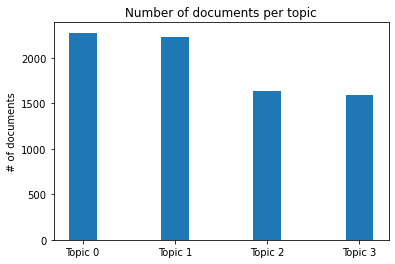

In [11]:
infered, ll = model.infer(corpus)
topic_data = np.zeros((len(infered),model.k2) )
for i, doc in enumerate(infered):
    temp = doc.get_sub_topics()
    for item in temp:
        topic_data[i, item[0]] = item[1]
topic_data = pd.DataFrame(topic_data)
topic_data["TOPIC"] = topic_data.apply(lambda x: np.argmax(x), axis=1)
topic_labels = topic_data["TOPIC"].values
plt.bar(["Topic %s" %i for i in range(model.k2)],topic_data["TOPIC"].value_counts(), width=0.3)
plt.title("Number of documents per topic")
plt.ylabel("# of documents")
plt.show()

### 5. Sentiment Analysis

Let's load sentiment Analyser (based on VADER library)

In [12]:
try:   
    sia = SentimentIntensityAnalyzer()
except:
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()
def return_sentiment(doc):
    """
    Helper function to estimate the sentiment scores
    """
    return sia.polarity_scores(" ".join([model.vocabs[w] for w in doc.words]))
print("Analyzer is ready")

Analyzer is ready


In [13]:
sentiment_data = np.zeros((len(infered), 4))
for i, doc in enumerate(infered):
    sentiment_data[i] = list(return_sentiment(doc).values())

keys = list(return_sentiment(doc).keys())
for i, k in enumerate(keys):
    topic_data[k] = sentiment_data[:,i]
print("Sentiments Calculated")

Sentiments Calculated


Now we can visualise the scores and the word distribution per topic

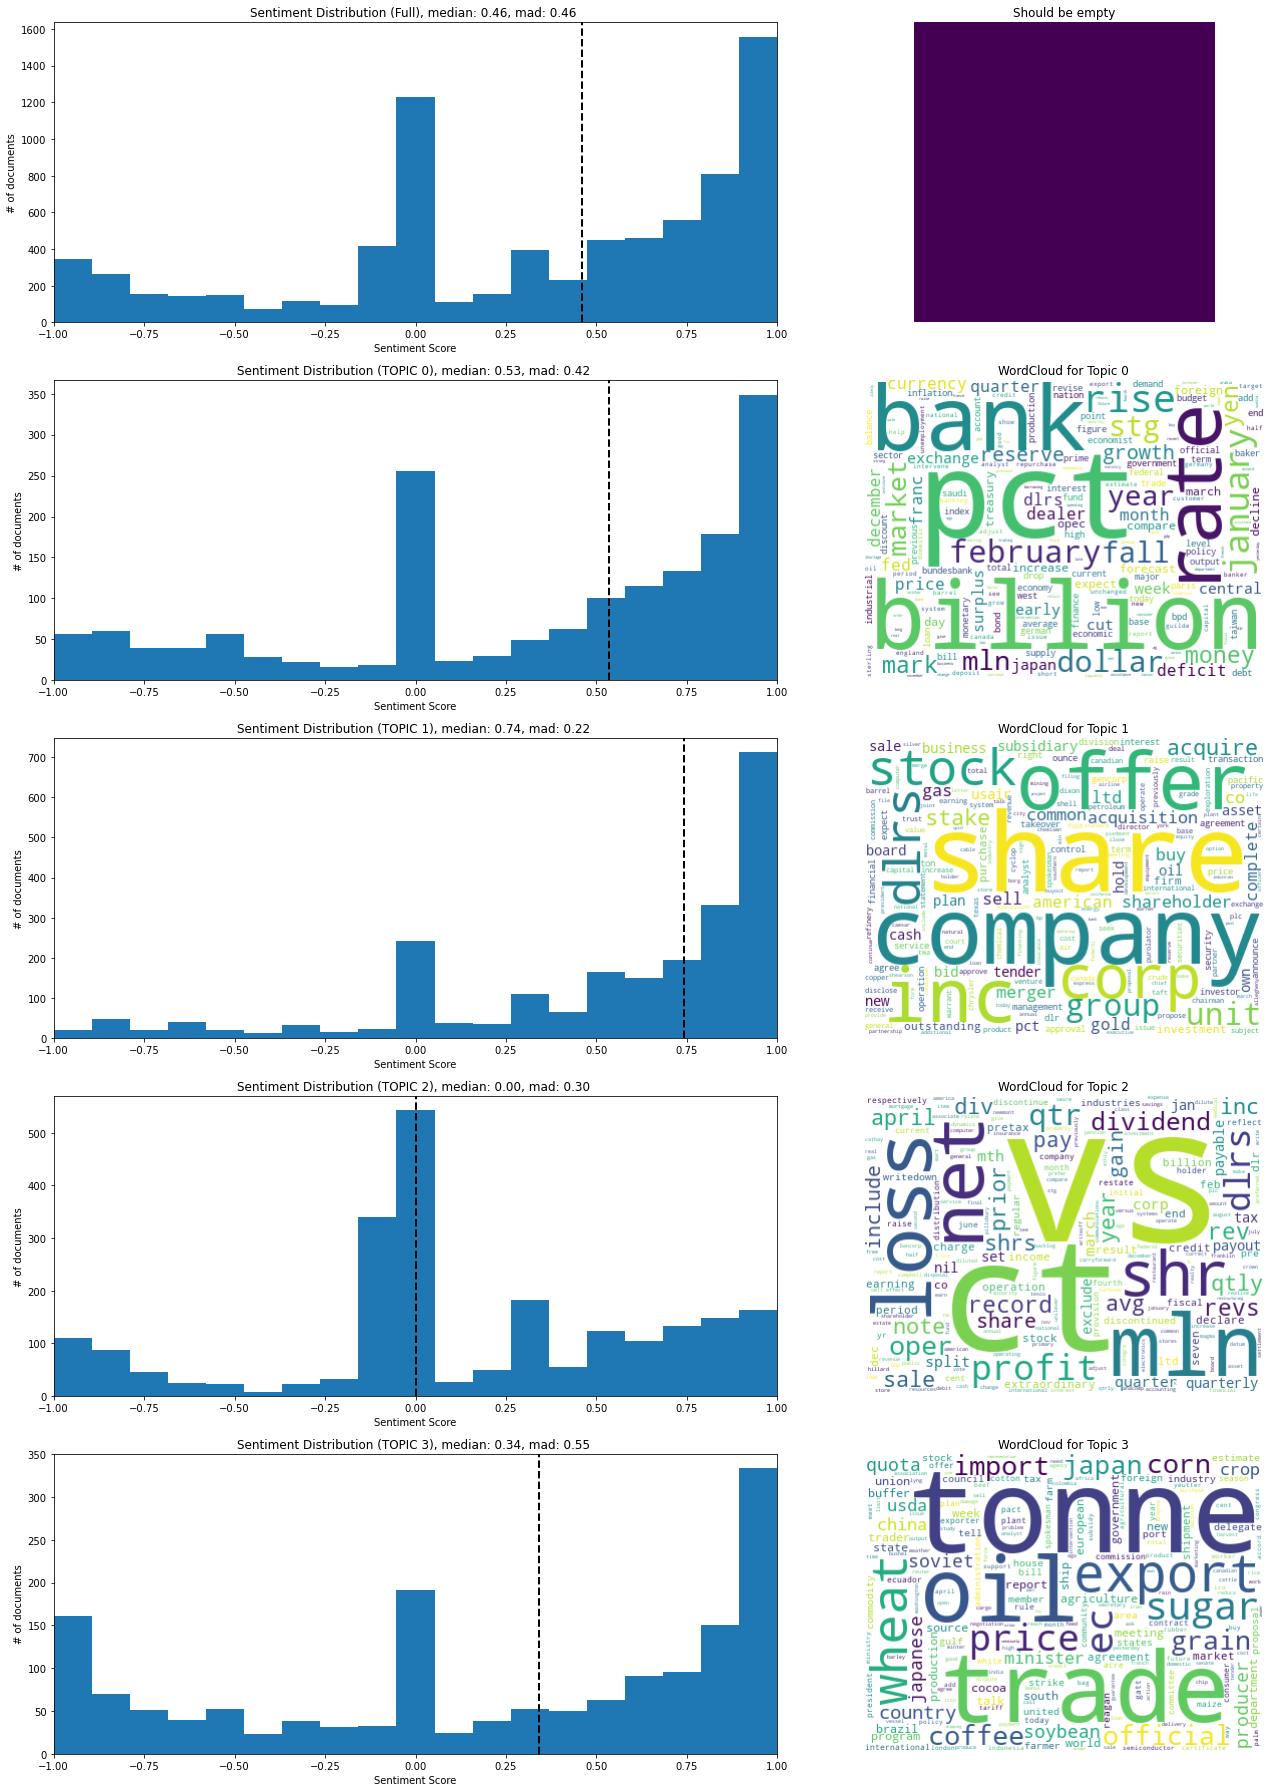

In [14]:
fig, ax = plt.subplots( model.k2 + 1,2, figsize=(20, 5 * (model.k2 + 1)))
bins = np.linspace(-1,1, 20)
################################
########   Overall
################################
scores = topic_data["compound"]
ax[0,0].hist(scores, bins=bins)
ax[0,0].set_title("Sentiment Distribution (Full), median: %.2f, mad: %.2f " %(np.median(scores),
                                                                                  median_abs_deviation(scores)))
ax[0,0].set_ylabel("# of documents")
ax[0,0].set_xlabel("Sentiment Score")
ax[0,0].axvline(scores.median(), color='k', linestyle='dashed', linewidth=2)
ax[0,0].set_xlim([-1,1])

ax[0,1].imshow(np.zeros((10,10)))
ax[0,1].set_title("Should be empty")
ax[0,1].axis("off")
###############################
########    Per topic 
###############################
wc = wordcloud.WordCloud(height=300, background_color="white")
for i in range(model.k2):
    scores = topic_data[topic_data["TOPIC"] == i]["compound"]
    ax[i + 1,0].hist(scores, bins=bins)
    ax[i + 1,0].set_ylabel("# of documents")
    ax[i + 1,0].set_xlim([-1,1])
    ax[i + 1,0].set_xlabel("Sentiment Score")
    ax[i + 1,0].set_title("Sentiment Distribution (TOPIC %s), median: %.2f, mad: %.2f " %(i, np.median(scores),
                                                                                  median_abs_deviation(scores)))
    ax[i + 1,0].axvline(scores.median(), color='k', linestyle='dashed', linewidth=2)

    vocab = dict()
    for item in model.get_topic_words(i, top_n=200):
        vocab[item[0]] = item[1]
    ax[i + 1,1].imshow(wc.generate_from_frequencies(vocab), interpolation="bilinear")
    ax[i + 1,1].set_title("WordCloud for Topic %s" %i)
    ax[i + 1,1].axis("off")
plt.tight_layout()
plt.show()